In [22]:
!python --version

Python 3.13.5


# MySQL connection with jupyter notebook

### install mysql-connector-python

In [23]:
#mysql connection with python
!conda install -c anaconda mysql-connector-python -y

3 channel Terms of Service accepted
Channels:
 - anaconda
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.



Import required libraries

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import calendar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# SQL
import mysql.connector as sql
# from sqlalchemy import create_engine  # Uncomment only if you're using SQLAlchemy

# Scikit-learn: Models & Preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder


# Storm Events Data Analysis

Let's explore the storm events data from the CSV file and database.

In [2]:
# If the data has been uploaded to the database, query it from there
# First, let's reconnect to the database
try:
    conn = sql.connect(
        host='localhost', 
        user='root', 
        password='cap4770',
        database= 'cap4770',  
        use_pure = True)
    
    cursor = conn.cursor(buffered=True)
    cursor.execute("use cap4770")
    
    # Check what tables are available
    cursor.execute("show tables")
    tables = cursor.fetchall()
    print("Available tables in the database:")
    for table in tables:
        print(f"- {table[0]}")
    
except Exception as e:
    print(f"Database connection error: {e}")
    print("Will work with CSV file instead.")

Available tables in the database:
- cap4
- stormevents_details


In [5]:
# Query storm events data from database (assuming table name is 'storm_events' or similar)
# You may need to adjust the table name based on how you uploaded the data

try:
    storm_table_name = 'stormevents_details'
    if storm_table_name:
        # Query the first 10 records from the database
        query = f"SELECT * FROM {storm_table_name} LIMIT 10"
        storm_df_db = pd.read_sql(query, conn)
        print(f"\nData from database table '{storm_table_name}':")
        print(f"Shape: {storm_df_db.shape}")
        storm_df_db.head()
    else:
        print("Storm events table not found in database. Please check the table name.")

        
except Exception as e:
    print(f"Error querying database: {e}")
    print("Working with CSV file data instead.")


Data from database table 'stormevents_details':
Shape: (10, 51)


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\535626275.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  storm_df_db = pd.read_sql(query, conn)


In [6]:

#searches database for the cost of damages from each weather event type and adds them together. Typecasts the damage_property and damage_crops
query = f"SELECT event_type, SUM(CASE WHEN damage_property LIKE '%k' THEN CAST(REPLACE(damage_property, 'k', '') AS DECIMAL(10,2)) * 1000 WHEN damage_property LIKE '%M' THEN CAST(REPLACE(damage_property, 'M', '') AS DECIMAL(10,2)) * 1000000 WHEN damage_property LIKE '%B' THEN CAST(REPLACE(damage_property, 'B', '') AS DECIMAL(10,2)) * 1000000000 ELSE CAST(damage_property AS DECIMAL(10,2)) END + CASE WHEN damage_crops LIKE '%k' THEN CAST(REPLACE(damage_crops, 'k', '') AS DECIMAL(10,2)) * 1000 WHEN damage_crops LIKE '%M' THEN CAST(REPLACE(damage_crops, 'M', '') AS DECIMAL(10,2)) * 1000000 WHEN damage_crops LIKE '%B' THEN CAST(REPLACE(damage_crops, 'B', '') AS DECIMAL(10,2)) * 1000000000 ELSE CAST(damage_crops AS DECIMAL(10,2)) END) AS total FROM {storm_table_name} GROUP BY event_type"
damage_db = pd.read_sql(query, conn)
# Sort by the 'total' column in descending order
damage_db = damage_db.sort_values(by='total', ascending=False)
#Formats cost into a readable format
pd.options.display.float_format = '${:,.0f}'.format
print(damage_db)


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\554082183.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  damage_db = pd.read_sql(query, conn)


                  event_type          total
14                   Tornado $9,137,004,100
7                      Flood $6,774,406,300
9                    Drought $2,484,117,500
10               Flash Flood $1,442,691,300
13                  Wildfire   $652,567,630
5          Thunderstorm Wind   $456,055,310
2             Tropical Storm   $453,641,200
22              Frost/Freeze   $349,290,000
6                       Hail   $329,399,800
34          Storm Surge/Tide   $239,294,000
19                 High Wind   $196,300,900
43       Hurricane (Typhoon)   $173,500,000
30                   Tsunami    $57,554,000
3                Strong Wind    $56,078,310
0               Winter Storm    $51,699,200
8                  Lightning    $42,126,220
35                  Blizzard    $39,655,000
28                 Ice Storm    $36,266,000
1                 Heavy Snow    $34,835,300
23                Heavy Rain    $32,589,000
32             Coastal Flood    $27,274,000
31               Debris Flow    

# Data Modelling

Let's model the data to predict damage cost based on the attributes given.

C:\Users\trist\AppData\Local\Temp\ipykernel_22436\2994661703.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Damage vs. Casualties correlation: 0.73
Slope: 0.000000, Intercept: 34.724717, R²: 0.529


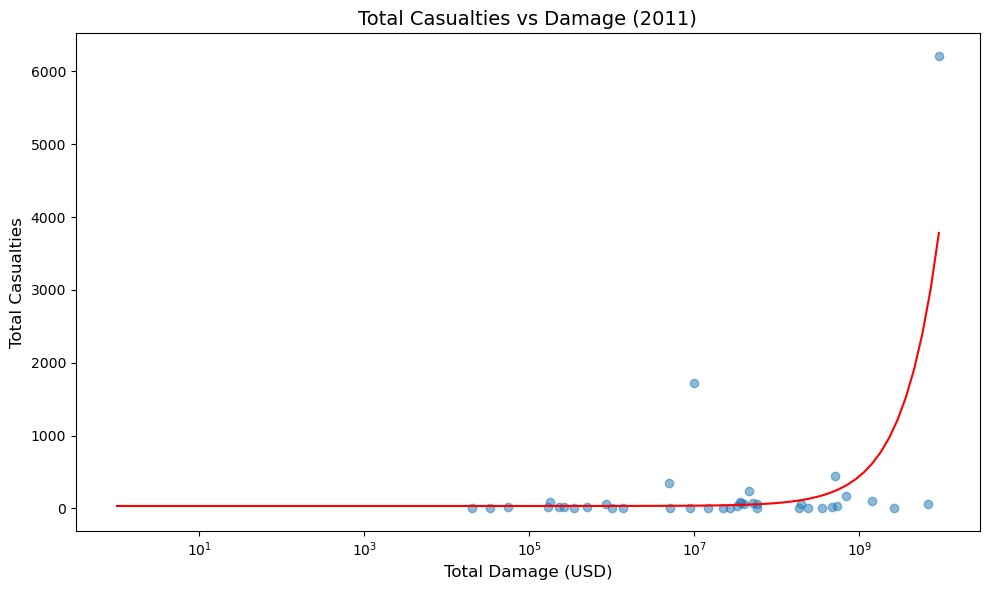

In [7]:
query = f"""
SELECT
  event_type,
  SUM(
    CASE 
      WHEN damage_property LIKE '%k' THEN CAST(REPLACE(damage_property,'k','') AS DECIMAL(10,2)) * 1000
      WHEN damage_property LIKE '%M' THEN CAST(REPLACE(damage_property,'M','') AS DECIMAL(10,2)) * 1000000
      WHEN damage_property LIKE '%B' THEN CAST(REPLACE(damage_property,'B','') AS DECIMAL(10,2)) * 1000000000
      ELSE CAST(COALESCE(damage_property,'0') AS DECIMAL(10,2))
    END
    +
    CASE
      WHEN damage_crops LIKE '%k' THEN CAST(REPLACE(damage_crops,'k','') AS DECIMAL(10,2)) * 1000
      WHEN damage_crops LIKE '%M' THEN CAST(REPLACE(damage_crops,'M','') AS DECIMAL(10,2)) * 1000000
      WHEN damage_crops LIKE '%B' THEN CAST(REPLACE(damage_crops,'B','') AS DECIMAL(10,2)) * 1000000000
      ELSE CAST(COALESCE(damage_crops,'0') AS DECIMAL(10,2))
    END
  ) AS total_damage,

  SUM(
    COALESCE(injuries_direct,  0) +
    COALESCE(injuries_indirect,0) +
    COALESCE(deaths_direct,    0) +
    COALESCE(deaths_indirect,  0)
  ) AS total_casualties

FROM {storm_table_name}
GROUP BY event_type;
"""

# Load data
df = pd.read_sql(query, conn)

# Drop rows with missing values
df = df.dropna(subset=['total_damage', 'total_casualties'])

# Compute correlation
corr = df['total_damage'].corr(df['total_casualties'])
print(f"Damage vs. Casualties correlation: {corr:.2f}")

# Fit regression
X = df[['total_damage']]
y = df['total_casualties']
model = LinearRegression().fit(X, y)
slope, intercept = model.coef_[0], model.intercept_
r2 = model.score(X, y)
print(f"Slope: {slope:.6f}, Intercept: {intercept:.6f}, R²: {r2:.3f}")


# Plot scatter and regression
plt.figure(figsize=(10,6))
plt.scatter(df['total_damage'], df['total_casualties'], alpha=0.5)
x_vals = np.logspace(np.log10(df['total_damage'].min()+1), np.log10(df['total_damage'].max()+1), 100)
plt.plot(x_vals, intercept + slope * x_vals, color='red')
plt.xscale('log')
plt.xlabel('Total Damage (USD)', fontsize=12)
plt.ylabel('Total Casualties', fontsize=12)
plt.title('Total Casualties vs Damage (2011)', fontsize=14)
plt.tight_layout()
plt.show()


The 2nd data model

C:\Users\trist\AppData\Local\Temp\ipykernel_22436\3490848803.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


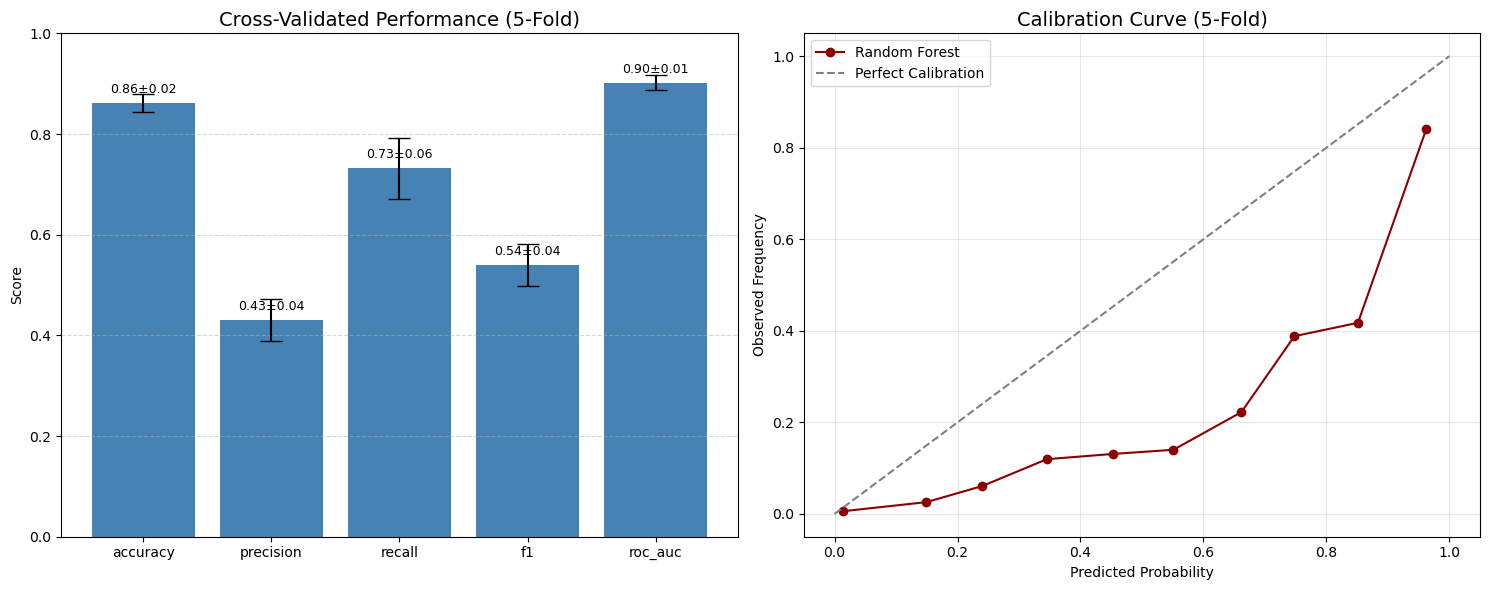

In [21]:
query = """
SELECT
  (CASE
     WHEN DAMAGE_PROPERTY LIKE '%k' THEN CAST(REPLACE(DAMAGE_PROPERTY,'k','') AS DECIMAL(20,2))*1000
     WHEN DAMAGE_PROPERTY LIKE '%M' THEN CAST(REPLACE(DAMAGE_PROPERTY,'M','') AS DECIMAL(20,2))*1000000
     WHEN DAMAGE_PROPERTY LIKE '%B' THEN CAST(REPLACE(DAMAGE_PROPERTY,'B','') AS DECIMAL(20,2))*1000000000
     ELSE CAST(DAMAGE_PROPERTY AS DECIMAL(20,2))
   END
   +
   CASE
     WHEN DAMAGE_CROPS LIKE '%k' THEN CAST(REPLACE(DAMAGE_CROPS,'k','') AS DECIMAL(20,2))*1000
     WHEN DAMAGE_CROPS LIKE '%M' THEN CAST(REPLACE(DAMAGE_CROPS,'M','') AS DECIMAL(20,2))*1000000
     WHEN DAMAGE_CROPS LIKE '%B' THEN CAST(REPLACE(DAMAGE_CROPS,'B','') AS DECIMAL(20,2))*1000000000
     ELSE CAST(DAMAGE_CROPS AS DECIMAL(20,2))
   END) AS total_damage,
  (COALESCE(INJURIES_DIRECT,0)
   + COALESCE(INJURIES_INDIRECT,0)
   + COALESCE(DEATHS_DIRECT,0)
   + COALESCE(DEATHS_INDIRECT,0)
  ) AS total_casualties,
  TOR_F_SCALE AS intensity
FROM stormevents_details
WHERE TOR_F_SCALE IS NOT NULL;
"""
df = pd.read_sql(query, conn)
df = df.dropna(subset=['total_damage', 'total_casualties', 'intensity'])
df['has_casualties'] = (df['total_casualties'] > 0).astype(int)
df['intensity'] = LabelEncoder().fit_transform(df['intensity'])

X = df[['total_damage', 'intensity']]
y = df['has_casualties']

# Setup model and CV
clf = RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_split=5, n_estimators=50, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Performance metrics collection
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = cross_validate(clf, X, y, cv=cv, scoring=scoring, return_train_score=False)
means = [np.mean(results[f'test_{m}']) for m in scoring]
stds = [np.std(results[f'test_{m}']) for m in scoring]

# Probabilities for calibration
probs = []
truths = []
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    probs.extend(y_proba)
    truths.extend(y_test)

# Calibration curve
prob_true, prob_pred = calibration_curve(truths, probs, n_bins=10)

# Combined Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(scoring, means, yerr=stds, capsize=8, color='steelblue')
ax1.set_ylim(0, 1)
ax1.set_title("Cross-Validated Performance (5-Fold)", fontsize=14)
ax1.set_ylabel("Score")
ax1.grid(axis='y', linestyle='--', alpha=0.5)
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{mean:.2f}±{std:.2f}", ha='center', fontsize=9)

# Calibration curve
ax2.plot(prob_pred, prob_true, marker='o', label='Random Forest', color='darkred')
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Observed Frequency')
ax2.set_title('Calibration Curve (5-Fold)', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Data Visualizations

Now let's create various graphs to visualize the storm events data from our complete database of 79,091 records.

In [25]:
# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

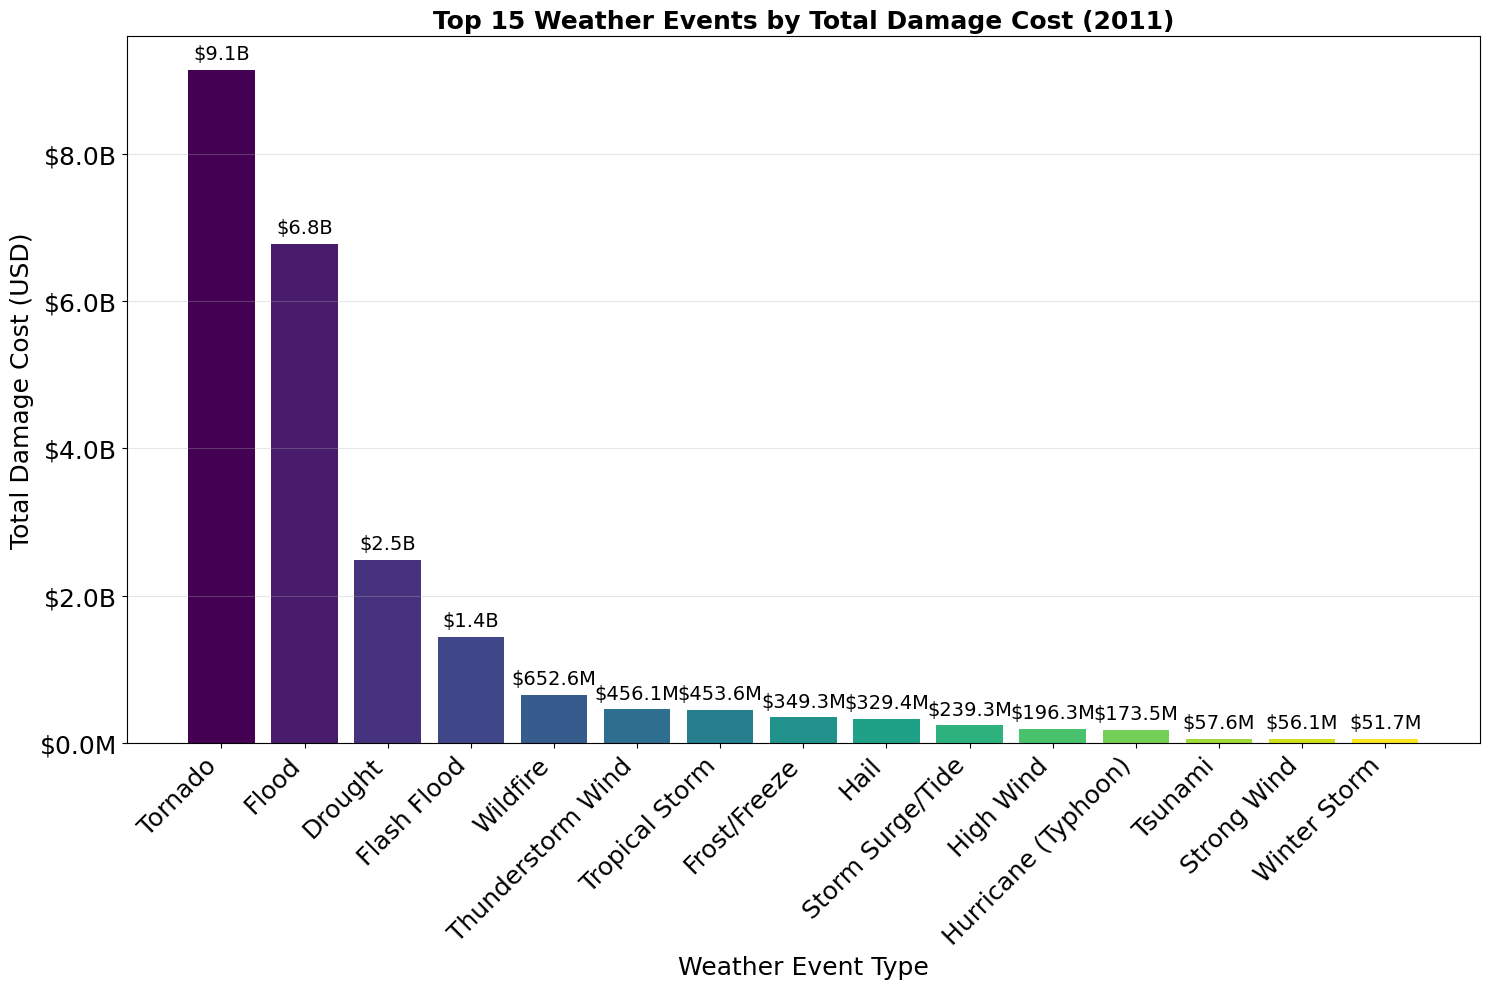

Total damage across all event types: $23,135,915,870


In [26]:
# Graph 1: Total Damage Costs by Event Type (Bar Chart)
plt.figure(figsize=(15, 10))

# Get top 15 most damaging event types for better readability
top_damage = damage_db.head(15)

# Create bar plot
bars = plt.bar(range(len(top_damage)), top_damage['total'],
               color=plt.cm.viridis(np.linspace(0, 1, len(top_damage))))

# Customize the plot
plt.title('Top 15 Weather Events by Total Damage Cost (2011)', fontsize=18, fontweight='bold')
plt.xlabel('Weather Event Type', fontsize=18)
plt.ylabel('Total Damage Cost (USD)', fontsize=18)
plt.xticks(range(len(top_damage)), top_damage['event_type'], rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)

# Format y-axis to show values in millions/billions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x < 1e9 else f'${x/1e9:.1f}B'))

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(top_damage['total'])*0.01,
             f'${height/1e6:.1f}M' if height < 1e9 else f'${height/1e9:.1f}B',
             ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total damage across all event types: ${damage_db['total'].sum():,.0f}")


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\247216858.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_frequency = pd.read_sql(query_freq, conn)


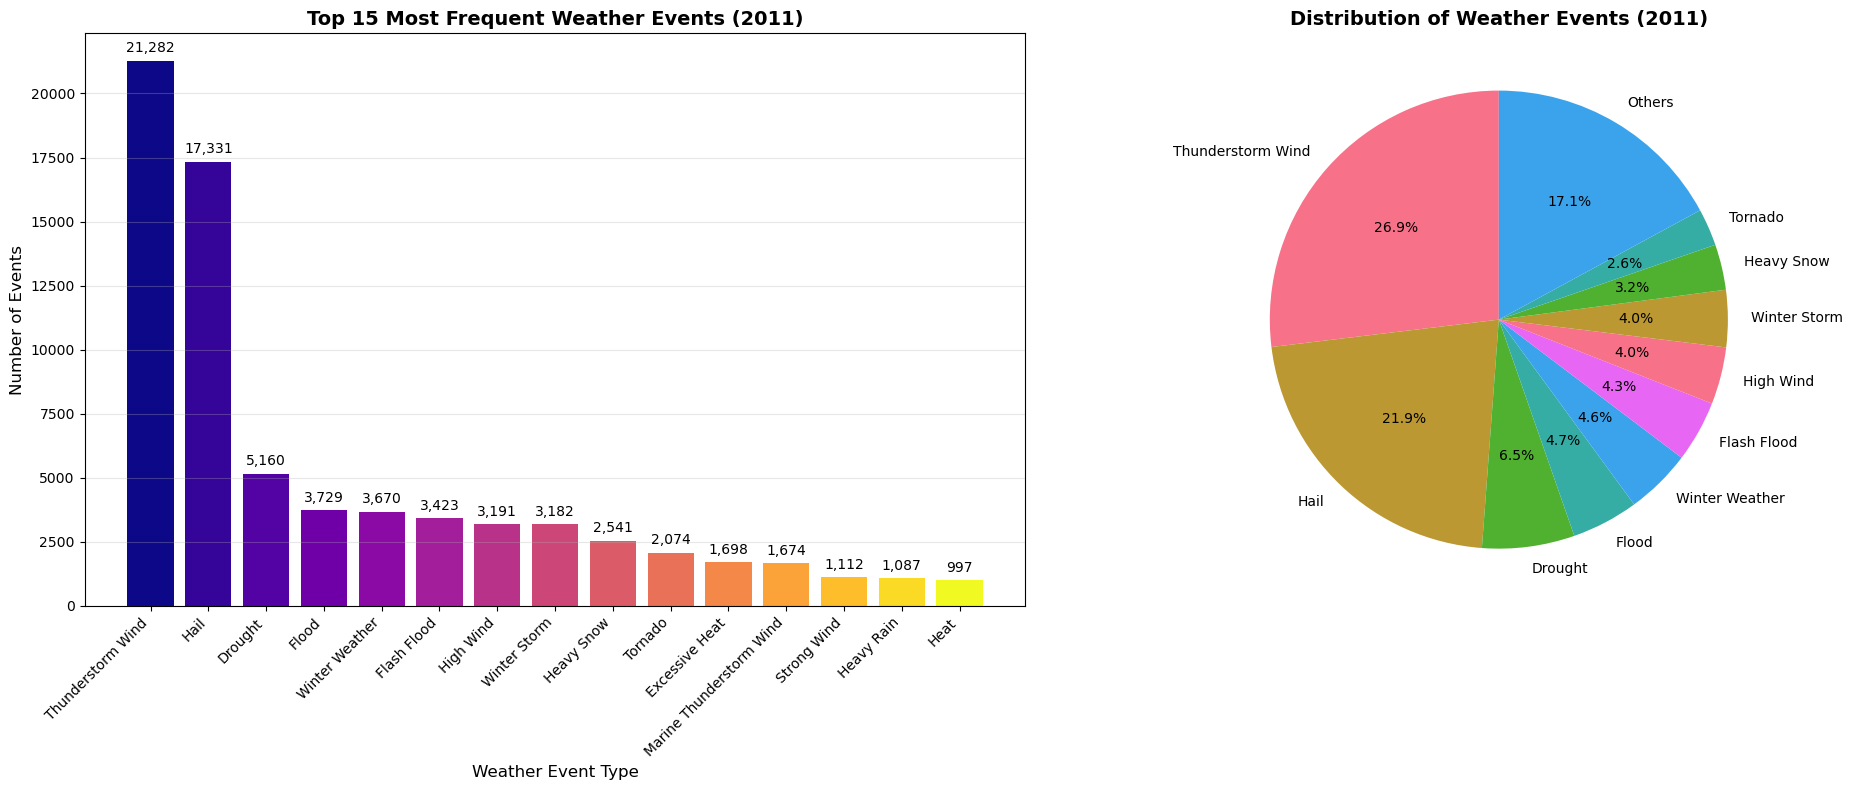

Total number of weather events: 79,091
Most common event: Thunderstorm Wind (21,282 occurrences)


In [27]:
# Graph 2: Event Frequency Analysis
# Get event frequency data from database
query_freq = f"SELECT event_type, COUNT(*) as frequency FROM {storm_table_name} GROUP BY event_type ORDER BY frequency DESC"
event_frequency = pd.read_sql(query_freq, conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart of top 15 most frequent events
top_freq = event_frequency.head(15)
bars1 = ax1.bar(range(len(top_freq)), top_freq['frequency'], 
                color=plt.cm.plasma(np.linspace(0, 1, len(top_freq))))
ax1.set_title('Top 15 Most Frequent Weather Events (2011)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Weather Event Type', fontsize=12)
ax1.set_ylabel('Number of Events', fontsize=12)
ax1.set_xticks(range(len(top_freq)))
ax1.set_xticklabels(top_freq['event_type'], rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(top_freq['frequency'])*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

ax1.grid(axis='y', alpha=0.3)

# Pie chart of top 10 events
top_10_freq = event_frequency.head(10)
others_freq = event_frequency.iloc[10:]['frequency'].sum()
pie_data = list(top_10_freq['frequency']) + [others_freq]
pie_labels = list(top_10_freq['event_type']) + ['Others']

ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Weather Events (2011)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total number of weather events: {event_frequency['frequency'].sum():,}")
print(f"Most common event: {event_frequency.iloc[0]['event_type']} ({event_frequency.iloc[0]['frequency']:,} occurrences)")

C:\Users\trist\AppData\Local\Temp\ipykernel_22436\3407847816.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_data = pd.read_sql(query_monthly, conn)


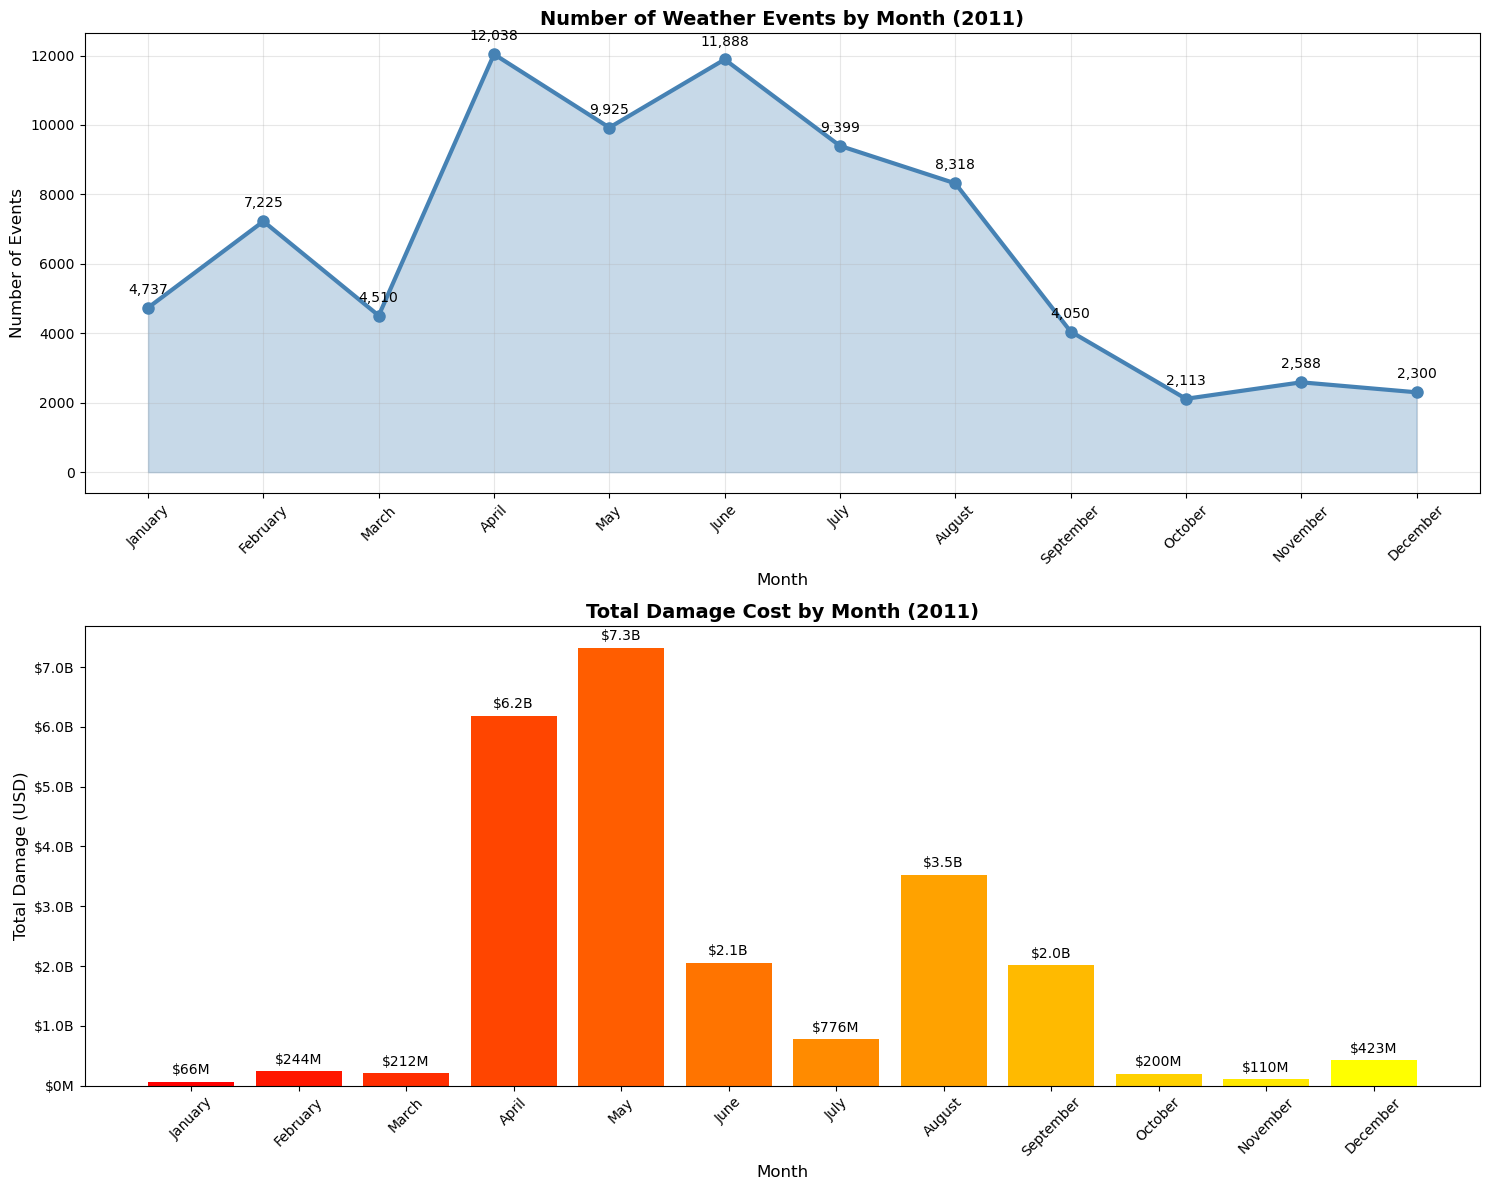

Monthly Summary:
January: 4,737 events, $66,238,330 damage
February: 7,225 events, $243,551,200 damage
March: 4,510 events, $211,779,000 damage
April: 12,038 events, $6,190,394,500 damage
May: 9,925 events, $7,325,129,450 damage
June: 11,888 events, $2,054,750,870 damage
July: 9,399 events, $776,397,050 damage
August: 8,318 events, $3,525,579,000 damage
September: 4,050 events, $2,008,733,720 damage
October: 2,113 events, $200,214,850 damage
November: 2,588 events, $110,040,550 damage
December: 2,300 events, $423,107,350 damage


In [28]:
# Graph 3: Monthly Timeline of Weather Events
# Get monthly event data
query_monthly = f"""
SELECT 
    MONTH(STR_TO_DATE(BEGIN_DATE_TIME, '%d-%b-%y %H:%i:%s')) as month,
    MIN(MONTHNAME(STR_TO_DATE(BEGIN_DATE_TIME, '%d-%b-%y %H:%i:%s'))) as month_name,
    COUNT(*) as event_count,
    SUM(CASE 
        WHEN damage_property LIKE '%k' THEN CAST(REPLACE(damage_property, 'k', '') AS DECIMAL(10,2)) * 1000 
        WHEN damage_property LIKE '%M' THEN CAST(REPLACE(damage_property, 'M', '') AS DECIMAL(10,2)) * 1000000 
        WHEN damage_property LIKE '%B' THEN CAST(REPLACE(damage_property, 'B', '') AS DECIMAL(10,2)) * 1000000000 
        ELSE CAST(damage_property AS DECIMAL(10,2)) 
    END + CASE 
        WHEN damage_crops LIKE '%k' THEN CAST(REPLACE(damage_crops, 'k', '') AS DECIMAL(10,2)) * 1000 
        WHEN damage_crops LIKE '%M' THEN CAST(REPLACE(damage_crops, 'M', '') AS DECIMAL(10,2)) * 1000000 
        WHEN damage_crops LIKE '%B' THEN CAST(REPLACE(damage_crops, 'B', '') AS DECIMAL(10,2)) * 1000000000 
        ELSE CAST(damage_crops AS DECIMAL(10,2)) 
    END) as total_damage
FROM {storm_table_name} 
GROUP BY month
ORDER by month
"""
monthly_data = pd.read_sql(query_monthly, conn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Event count by month
ax1.plot(monthly_data['month_name'], monthly_data['event_count'], 
         marker='o', linewidth=3, markersize=8, color='steelblue')
ax1.fill_between(monthly_data['month_name'], monthly_data['event_count'], alpha=0.3, color='steelblue')
ax1.set_title('Number of Weather Events by Month (2011)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Number of Events', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for i, (month, count) in enumerate(zip(monthly_data['month_name'], monthly_data['event_count'])):
    ax1.annotate(f'{count:,}', (i, count), textcoords="offset points", xytext=(0,10), ha='center')

# Total damage by month
bars2 = ax2.bar(monthly_data['month_name'], monthly_data['total_damage'], 
                color=plt.cm.autumn(np.linspace(0, 1, len(monthly_data))))
ax2.set_title('Total Damage Cost by Month (2011)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Total Damage (USD)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M' if x < 1e9 else f'${x/1e9:.1f}B'))

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(monthly_data['total_damage'])*0.01,
             f'${height/1e6:.0f}M' if height < 1e9 else f'${height/1e9:.1f}B',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Monthly Summary:")
for _, row in monthly_data.iterrows():
    print(f"{row['month_name']}: {row['event_count']:,} events, ${row['total_damage']:,.0f} damage")

In [29]:
# Graph 4: Interactive Plotly Visualization - Damage vs Frequency Scatter Plot
# Merge damage and frequency data
damage_freq = pd.merge(damage_db, event_frequency, on='event_type', how='inner')

# Create interactive scatter plot
fig = px.scatter(damage_freq, 
                 x='frequency', 
                 y='total', 
                 size='total',
                 hover_name='event_type',
                 title='Weather Events: Damage Cost vs Frequency (2011)',
                 labels={
                     'frequency': 'Number of Events',
                     'total': 'Total Damage Cost (USD)',
                     'event_type': 'Event Type'
                 },
                 color='total',
                 color_continuous_scale='Viridis')

# Update layout
fig.update_layout(
    width=800,
    height=600,
    title_font_size=16,
    showlegend=False
)

# Format hover template
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Events: %{x:,}<br>' +
                  'Total Damage: $%{y:,.0f}<br>' +
                  '<extra></extra>'
)

fig.show()

# Show summary statistics
print("Correlation Analysis:")
correlation = damage_freq['frequency'].corr(damage_freq['total'])
print(f"Correlation between frequency and damage: {correlation:.3f}")
print(f"This indicates a {'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.3 else 'weak'} {'positive' if correlation > 0 else 'negative'} relationship.")

Correlation Analysis:
Correlation between frequency and damage: 0.130
This indicates a weak positive relationship.


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\348905159.py:22: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



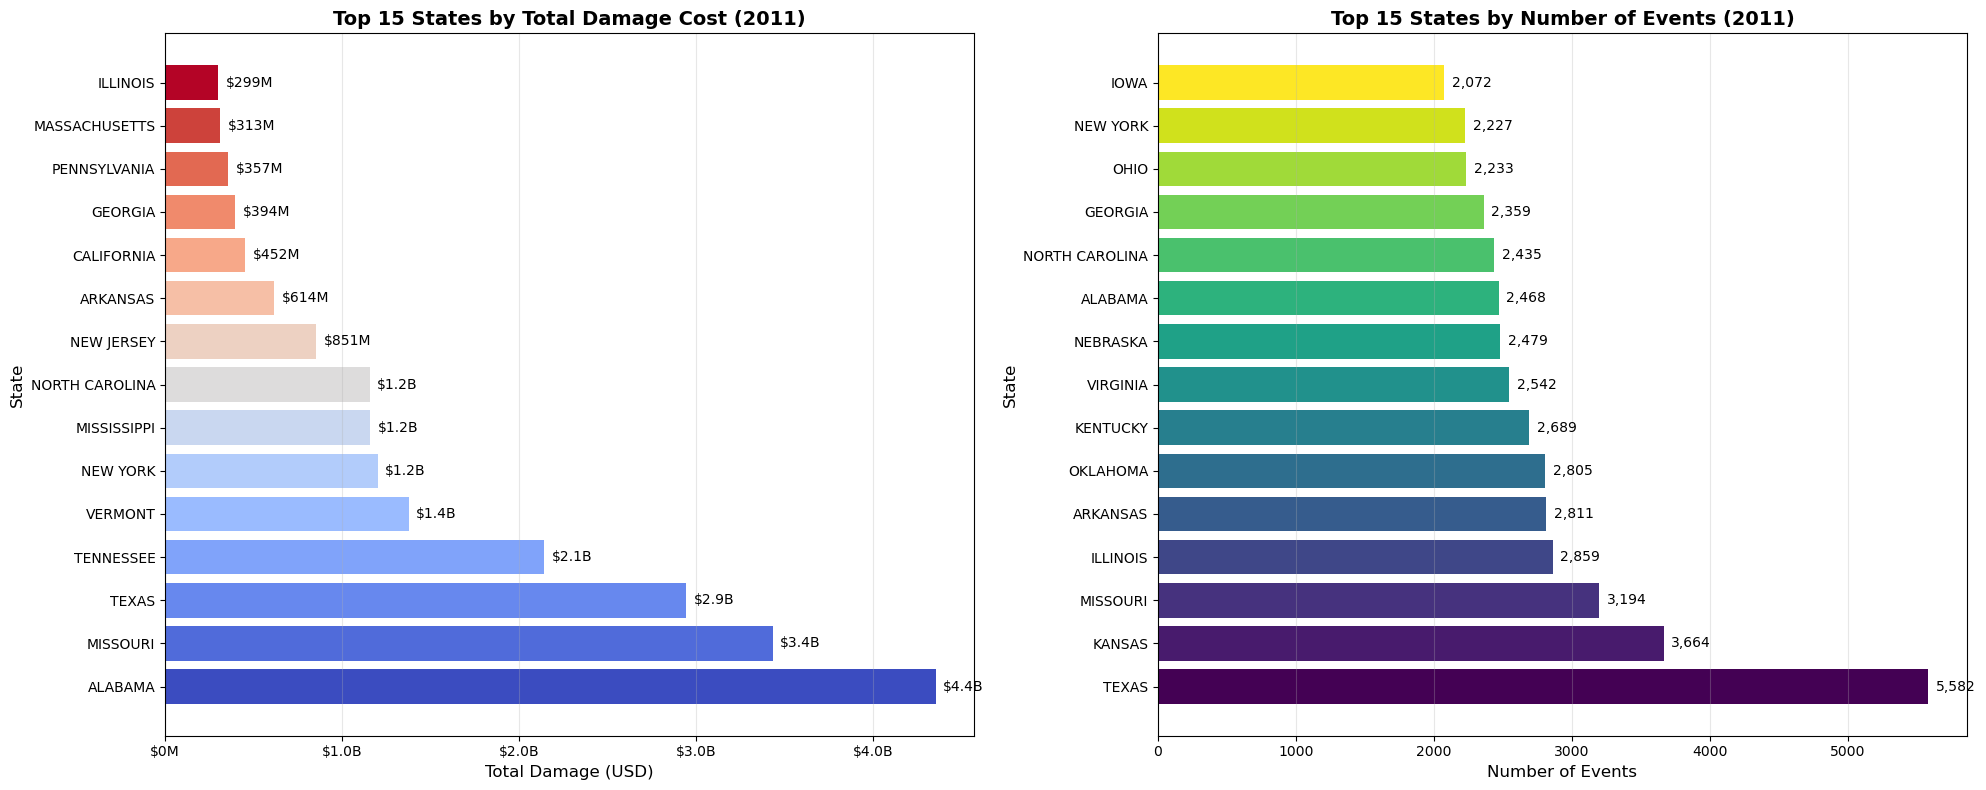

Top 5 States Summary:
ALABAMA: 2,468 events, $4,354,354,850 damage
MISSOURI: 3,194 events, $3,432,789,850 damage
TEXAS: 5,582 events, $2,944,607,400 damage
TENNESSEE: 2,038 events, $2,140,385,900 damage
VERMONT: 572 events, $1,375,993,000 damage


In [30]:
# Graph 5: Geographic Distribution by State
# Get state-wise data
query_states = f"""
SELECT 
    state,
    COUNT(*) as event_count,
    SUM(CASE 
        WHEN damage_property LIKE '%k' THEN CAST(REPLACE(damage_property, 'k', '') AS DECIMAL(10,2)) * 1000 
        WHEN damage_property LIKE '%M' THEN CAST(REPLACE(damage_property, 'M', '') AS DECIMAL(10,2)) * 1000000 
        WHEN damage_property LIKE '%B' THEN CAST(REPLACE(damage_property, 'B', '') AS DECIMAL(10,2)) * 1000000000 
        ELSE CAST(damage_property AS DECIMAL(10,2)) 
    END + CASE 
        WHEN damage_crops LIKE '%k' THEN CAST(REPLACE(damage_crops, 'k', '') AS DECIMAL(10,2)) * 1000 
        WHEN damage_crops LIKE '%M' THEN CAST(REPLACE(damage_crops, 'M', '') AS DECIMAL(10,2)) * 1000000 
        WHEN damage_crops LIKE '%B' THEN CAST(REPLACE(damage_crops, 'B', '') AS DECIMAL(10,2)) * 1000000000 
        ELSE CAST(damage_crops AS DECIMAL(10,2)) 
    END) as total_damage
FROM {storm_table_name} 
GROUP BY state 
ORDER BY total_damage DESC
"""
state_data = pd.read_sql(query_states, conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top 15 states by damage
top_states_damage = state_data.head(15)
bars1 = ax1.barh(range(len(top_states_damage)), top_states_damage['total_damage'], 
                 color=plt.cm.coolwarm(np.linspace(0, 1, len(top_states_damage))))
ax1.set_title('Top 15 States by Total Damage Cost (2011)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total Damage (USD)', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
ax1.set_yticks(range(len(top_states_damage)))
ax1.set_yticklabels(top_states_damage['state'])
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M' if x < 1e9 else f'${x/1e9:.1f}B'))

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + max(top_states_damage['total_damage'])*0.01, bar.get_y() + bar.get_height()/2,
             f'${width/1e6:.0f}M' if width < 1e9 else f'${width/1e9:.1f}B',
             ha='left', va='center', fontsize=10)

ax1.grid(axis='x', alpha=0.3)

# Top 15 states by event count
top_states_count = state_data.nlargest(15, 'event_count')
bars2 = ax2.barh(range(len(top_states_count)), top_states_count['event_count'], 
                 color=plt.cm.viridis(np.linspace(0, 1, len(top_states_count))))
ax2.set_title('Top 15 States by Number of Events (2011)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Events', fontsize=12)
ax2.set_ylabel('State', fontsize=12)
ax2.set_yticks(range(len(top_states_count)))
ax2.set_yticklabels(top_states_count['state'])

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + max(top_states_count['event_count'])*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}', ha='left', va='center', fontsize=10)

ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Top 5 States Summary:")
for i, row in state_data.head(5).iterrows():
    print(f"{row['state']}: {row['event_count']:,} events, ${row['total_damage']:,.0f} damage")

C:\Users\trist\AppData\Local\Temp\ipykernel_22436\1156304522.py:13: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



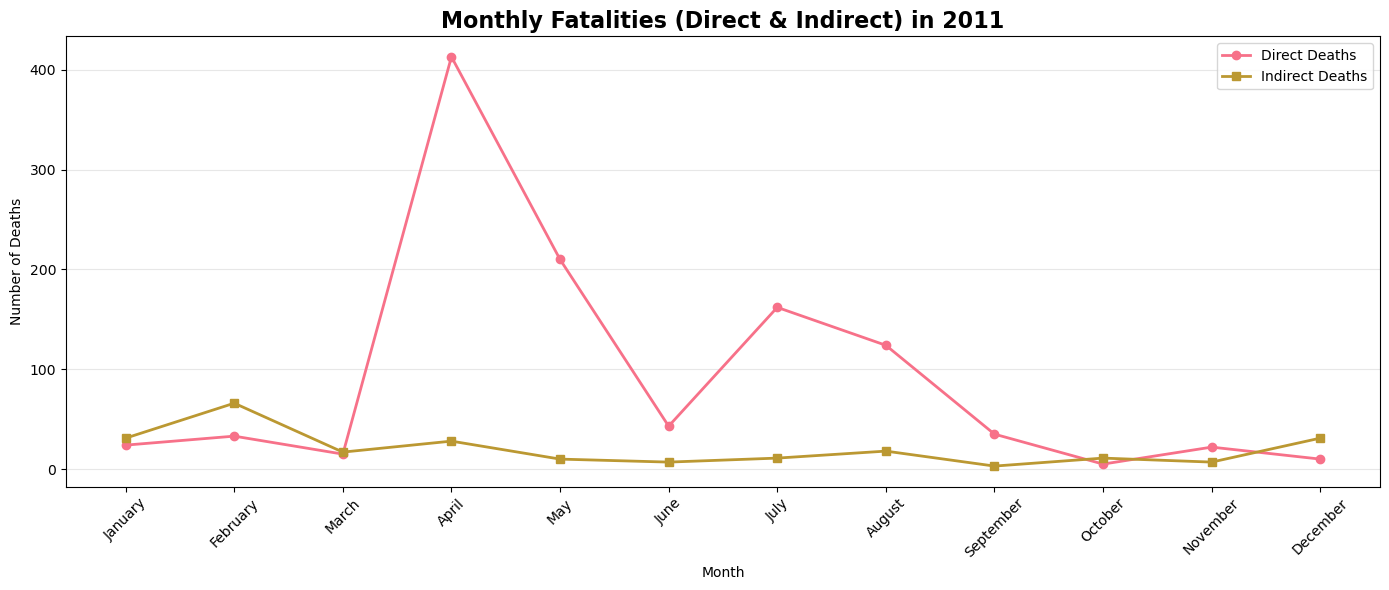

In [31]:
# Show monthly fatalities (direct/indirect)
query_fatalities_by_month = f"""
SELECT
    MONTH(STR_TO_DATE(BEGIN_DATE_TIME, '%d-%b-%y %H:%i:%s')) AS month_num,
    SUM(DEATHS_DIRECT) AS direct_deaths,
    SUM(DEATHS_INDIRECT) AS indirect_deaths
FROM {storm_table_name}
WHERE BEGIN_DATE_TIME IS NOT NULL
GROUP BY month_num
ORDER BY month_num
"""

fatalities_monthly = pd.read_sql(query_fatalities_by_month, conn)

# Clean and plot
fatalities_monthly = fatalities_monthly.dropna(subset=['month_num'])
fatalities_monthly['month_num'] = fatalities_monthly['month_num'].astype(int)
fatalities_monthly['month_name'] = fatalities_monthly['month_num'].apply(lambda m: calendar.month_name[m])

plt.figure(figsize=(14, 6))
plt.plot(fatalities_monthly['month_name'], fatalities_monthly['direct_deaths'],
         marker='o', linewidth=2, label='Direct Deaths')
plt.plot(fatalities_monthly['month_name'], fatalities_monthly['indirect_deaths'],
         marker='s', linewidth=2, label='Indirect Deaths')
plt.title('Monthly Fatalities (Direct & Indirect) in 2011', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\4032108409.py:16: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



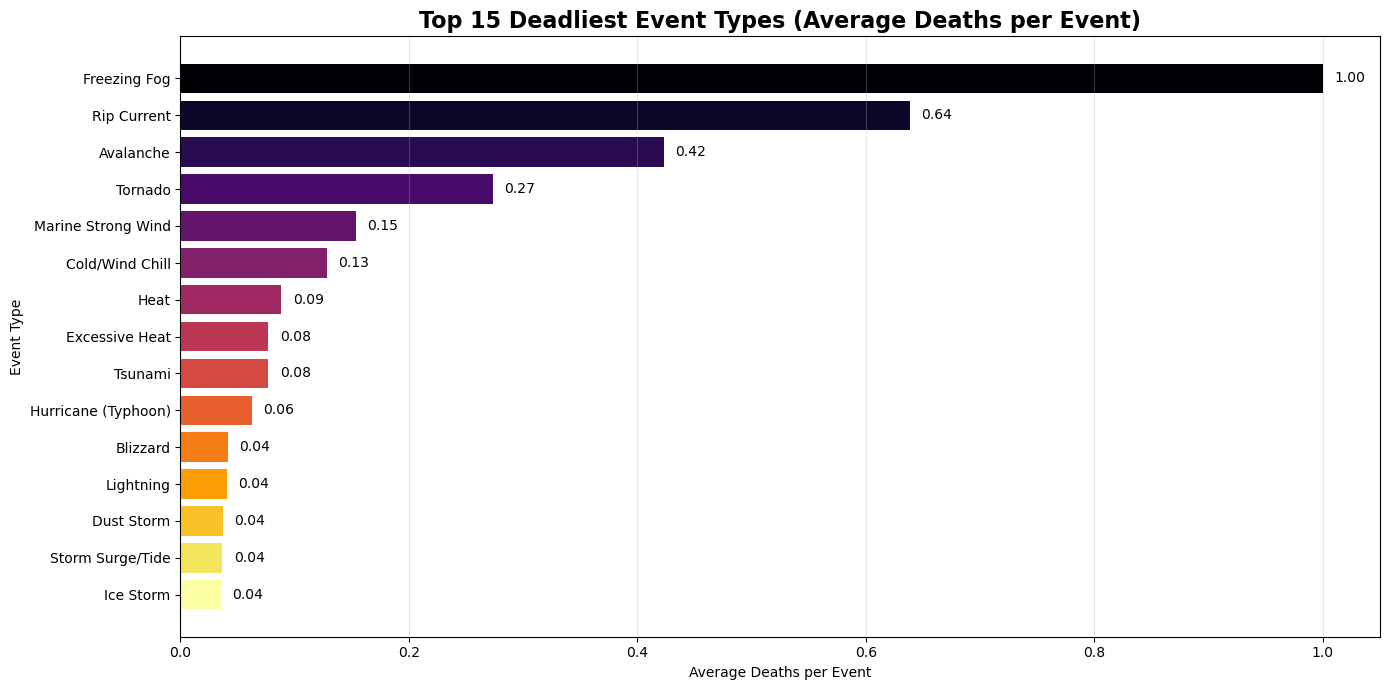

In [32]:
# Average Deaths per Event Type (Direct + Indirect)

query_avg_deaths = f"""
SELECT
    event_type,
    COUNT(*) AS event_count,
    SUM(DEATHS_DIRECT + DEATHS_INDIRECT) AS total_deaths,
    AVG(DEATHS_DIRECT + DEATHS_INDIRECT) AS avg_deaths_per_event
FROM {storm_table_name}
GROUP BY event_type
HAVING total_deaths > 0
ORDER BY avg_deaths_per_event DESC
LIMIT 15
"""

avg_deaths_df = pd.read_sql(query_avg_deaths, conn)

plt.figure(figsize=(14, 7))
bars = plt.barh(avg_deaths_df['event_type'], avg_deaths_df['avg_deaths_per_event'],
                color=plt.cm.inferno(np.linspace(0, 1, len(avg_deaths_df))))

plt.title('Top 15 Deadliest Event Types (Average Deaths per Event)', fontsize=16, fontweight='bold')
plt.xlabel('Average Deaths per Event')
plt.ylabel('Event Type')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\trist\AppData\Local\Temp\ipykernel_22436\143637017.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



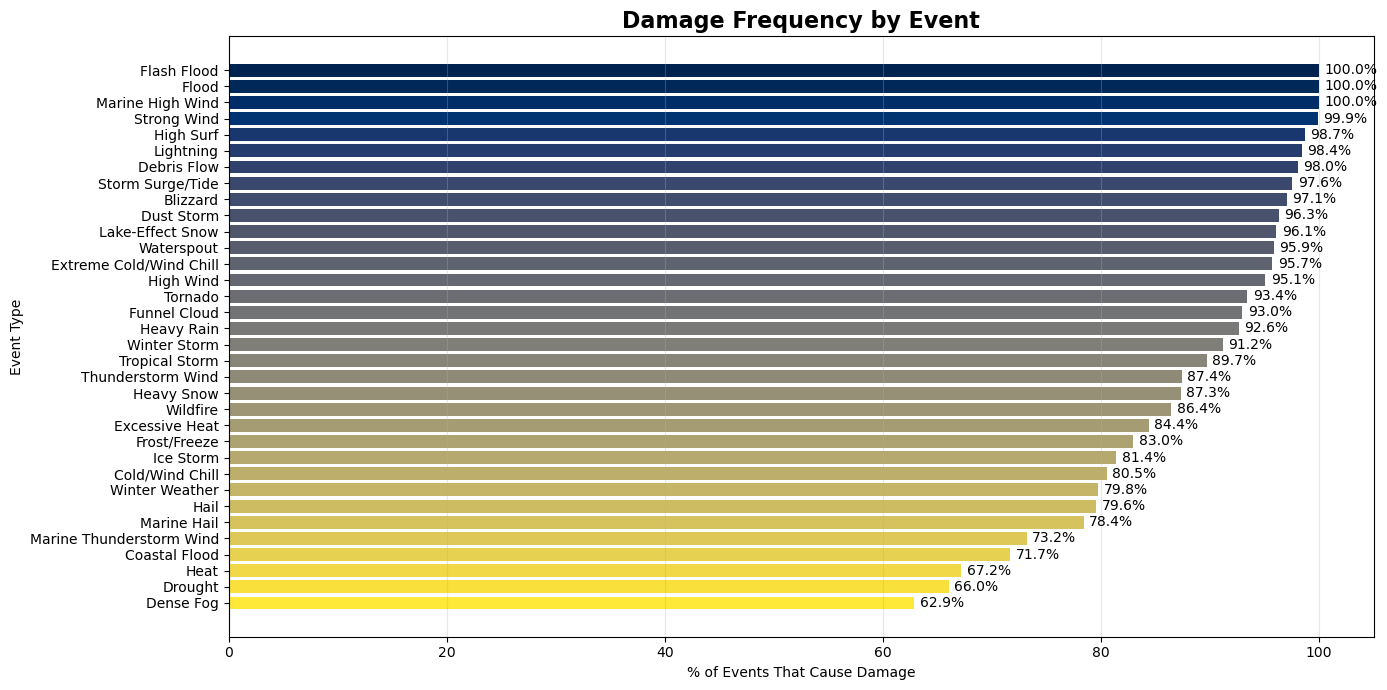

In [33]:
# Damage Frequency by Event
query_damage_likelihood = f"""
SELECT
    event_type,
    COUNT(*) AS total_events,
    SUM(CASE
        WHEN damage_property REGEXP '[0-9]' OR damage_crops REGEXP '[0-9]' THEN 1
        ELSE 0
    END) AS damaging_events
FROM {storm_table_name}
GROUP BY event_type
HAVING total_events > 50
"""

damage_likelihood_df = pd.read_sql(query_damage_likelihood, conn)
damage_likelihood_df['percent_damaging'] = (
    damage_likelihood_df['damaging_events'] / damage_likelihood_df['total_events']
) * 100

# Sort by percent_damaging
damage_likelihood_df = damage_likelihood_df.sort_values(by='percent_damaging', ascending=False)

# Plot
plt.figure(figsize=(14, 7))
bars = plt.barh(damage_likelihood_df['event_type'], damage_likelihood_df['percent_damaging'],
                color=plt.cm.cividis(np.linspace(0, 1, len(damage_likelihood_df))))

plt.title('Damage Frequency by Event', fontsize=16, fontweight='bold')
plt.xlabel('% of Events That Cause Damage')
plt.ylabel('Event Type')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()